# Q1
## 1.1

Given the multi-object linear Gaussian Hidden Markov Model (MOHMM) for tracking $K$ interacting objects. Each object evolves in a 4-dimensional state space (position and velocity), and the overall system is modeled using Kronecker products to build block-diagonal matrices.

We have the HMM:
\begin{align*}
\pi_0(x_0) &= \mathcal{N}(x_0; m_0, P_0) \\
\tau(x_t | x_{t-1}) &= \mathcal{N}(x_t; A x_{t-1}, Q) \\
g(y_t | x_t) &= \mathcal{N}(y_t; H x_t, R)
\end{align*}

With params:
\begin{align*}
A &= \begin{bmatrix}
I_2 & \kappa I_2 \\
0_{2\times 2} & 0.99 I_2
\end{bmatrix}, \quad
H = I_4, \quad
Q = \begin{bmatrix}
\frac{\kappa^3}{3} I_2 & \frac{\kappa^2}{2} I_2 \\
\frac{\kappa^2}{2} I_2 & \kappa I_2
\end{bmatrix}, \quad
R = r I_4
\end{align*}

To scale this model to $K$ objects, we define four $4K \times 4K$ matrices:
\begin{align*}
\bar{A}_K = I_K \otimes A, \quad
\bar{Q}_K = I_K \otimes Q + L L^\top,, \quad
\bar{H}_K = I_K \otimes H, \quad
\bar{R}_K = I_K \otimes R
\end{align*}

where $L$ is a zero-mean Gaussian random matrix with standard deviation $\sigma_L$.

To generate data from this model, we do:

- Sample $x_0 \sim \mathcal{N}(m_0^{(K)}, P_0^{(K)})$
- For $t = 1$ to $T$:

    - Sample $x_t \sim \mathcal{N}(\bar{A}_K x_{t-1}, \bar{Q}_K)$
    - Sample $y_t \sim \mathcal{N}(\bar{H}_K x_t, \bar{R}_K)$
    


We implemented the above simulator and tested it for $K = 1, 2, 5$ objects. For each case, we plot the observed data $y_t$ and the first two dimensions of the true trajectories of each object.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

I2 = np.eye(2)
I4 = np.eye(4)

kappa=0.1
r = 0.1
A = np.block([
    [I2, kappa * I2],
    [np.zeros((2, 2)), 0.99 * I2]
])

Q = np.block([
    [(kappa**3 / 3) * I2, (kappa**2 / 2) * I2],
    [(kappa**2 / 2) * I2, kappa * I2]
])

H = I4
R = r * I4

# since Q_bar is random, we want to save it for each K
Q_ks = {}

def simulate_MOHMM(K, T=400, sigma_L=0.5, seed=42):
    if seed is not None:
        np.random.seed(seed)

    # Block-diagonal for K objects
    AK = np.kron(np.eye(K), A)
    QK = np.kron(np.eye(K), Q)
    HK = np.kron(np.eye(K), H)
    RK = np.kron(np.eye(K), R)

    dim = 4 * K

    # since Q_bar is random, we want to save it for each K
    L = np.random.normal(0, sigma_L, size=(dim, dim))
    Q_bar_K = QK + L @ L.T
    Q_ks[K] = Q_bar_K

    # same m0 for all K objects, size (4K, )
    m0 = np.tile(np.array([0, 0, -20, 20]), K)
    P0 = np.eye(dim)
    x = np.random.multivariate_normal(m0, P0)

    X = [x.copy()]
    Y = []

    for _ in range(T):
        x = np.random.multivariate_normal(AK @ x, Q_bar_K)
        y = np.random.multivariate_normal(HK @ x, RK)
        X.append(x.copy())
        Y.append(y.copy())

    X = np.array(X)  # shape: (T+1, 4K)
    Y = np.array(Y)  # shape: (T, 4K)
    return X, Y

def plot_trajectories(X_list, K_list):
    plt.figure(figsize=(5, 5))
    
    for X, K in zip(X_list, K_list):
        for k in range(K): # loop over objects
            pos_x = X[:, 4*k + 0]
            pos_y = X[:, 4*k + 1]
            label = f"K={K}, Obj {k+1}"
            plt.plot(pos_x, pos_y, label=label)
    
    plt.xlabel("Position X")
    plt.ylabel("Position Y")
    plt.title("True Trajectories of Objects (First Two Dimensions)")
    plt.legend(prop={'size': 6})
    plt.grid(True)
    plt.tight_layout()
    plt.show()



We simulate 

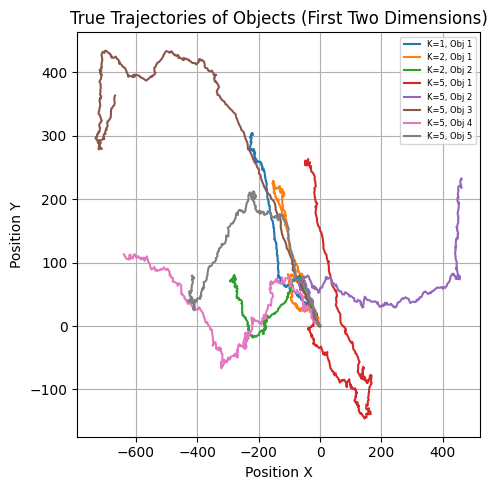

In [2]:
X1, Y1 = simulate_MOHMM(K=1, seed=42)
X2, Y2 = simulate_MOHMM(K=2, seed=42)
X5, Y5 = simulate_MOHMM(K=5, seed=42)

plot_trajectories([X1, X2, X5], [1, 2, 5])
# add observed y


## 1.2 Kalman Filter

### (a)

Given the HMM setup:
\begin{align*}
x_0 &\sim \mathcal{N}(m_0, P_0) \\
x_t \mid x_{t-1} &\sim \mathcal{N}(A x_{t-1}, Q) \\
y_t \mid x_t &\sim \mathcal{N}(H x_t, R)
\end{align*}

At each time step $t$, the Kalman filter computes the posterior distribution
$p(x_t \mid y_{1:t}) = \mathcal{N}(x_t; m_t, P_t)$

In this setting, we have:

- Input:
Starting point $ (m_0)_K \in R^{4K}, P_0=I_{4K} $, and the sequence of observations $ y_{1:T} $ for the specific T.

- Filtering:  
**For** $ n = 1, \dots, T $ **do**
    - Prediction step:
    \begin{align*}
    \hat{m}_t &= A_k m_{t-1} \\
    \hat{P}_t &= A_k P_{t-1} A_k^\top + Q
    \end{align*}

    - Update step:
    \begin{align*}
    K_t &= \hat{P}_t H^\top (H \hat{P}_t H^\top + R)^{-1} \\
    m_t &= \hat{m}_t + K_t (y_t - H \hat{m}_t) \\
    P_t &= (I - K_t H) \hat{P}_t
    \end{align*}

**End for**    

- Return $ m_{0:T}, P_{0:T}$

Here, $K_t$ is the Kalman gain matrix, and $m_t$, $P_t$ represent the posterior mean and covariance of the filtered state estimate at time $t$.



### (b)

In [3]:
def kalman_filter(Y, A, Q, H, R, m0, P0):
    T = len(Y)
    dim_x = len(m0) # 4K
    I = np.eye(dim_x)

    m = m0.copy()
    P = P0.copy()
    M_list = []
    P_list = []

    for t in range(T):
        # Prediction step
        m_pred = A @ m
        P_pred = A @ P @ A.T + Q

        # Update step
        y = Y[t]
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)
        m = m_pred + K @ (y - H @ m_pred)
        P = (I - K @ H) @ P_pred

        M_list.append(m.copy())
        P_list.append(P.copy())

    return np.array(M_list), P_list


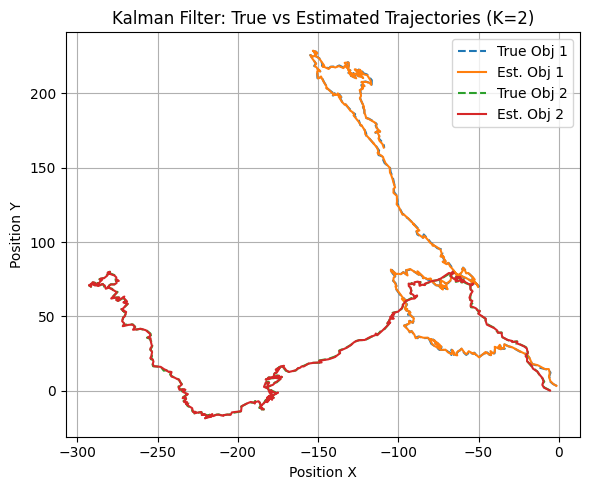

NMSE for K=2: 9.795175704546012e-06


In [4]:
def compute_nmse(true, est):
    """
    NMSE over sequence: true and est are shape (T+1, dim)
    """
    num = np.sum((true[1:] - est)**2)
    denom = np.sum(true[1:]**2)
    return num / denom

def run_kalman(X, Y, K, plot_trajectories = False):
    dim = 4 * K

    AK = np.kron(np.eye(K), A)
    QK = np.kron(np.eye(K), Q)
    HK = np.kron(np.eye(K), H)
    RK = np.kron(np.eye(K), R)

    # get stored Q_bar for this K
    Q_bar = Q_ks[K] 

    m0 = np.tile(np.array([0, 0, -20, 20]), K)
    P0 = np.eye(dim)

    # Step 2: Kalman filtering
    filtered_means, _ = kalman_filter(Y, AK, Q_bar, HK, RK, m0, P0)

    # Step 3: NMSE
    nmse = compute_nmse(X, filtered_means)

    # Step 4: Plot true vs estimated (position only)
    if plot_trajectories: 
        plt.figure(figsize=(6, 5))
        for k in range(K):
            idx_x = 4*k
            idx_y = 4*k + 1
            plt.plot(X[1:, idx_x], X[1:, idx_y], label=f"True Obj {k+1}", linestyle="--")
            plt.plot(filtered_means[:, idx_x], filtered_means[:, idx_y], label=f"Est. Obj {k+1}")
        plt.xlabel("Position X")
        plt.ylabel("Position Y")
        plt.title(f"Kalman Filter: True vs Estimated Trajectories (K={K})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return nmse

# Run it on the simulated X2 and Y2
nmse = run_kalman(X2, Y2, K=2, plot_trajectories=True)
print(f"NMSE for K=2: {nmse}")


We have the visual plot for K = 2 for the sanity check. We can see that for the 2 objects simulated,
the trajectories of first 2 dims of both objects are almost perfectly estimated by the Kalman filter.

This agrees with the produced NMSE of 1e-05, which is really small.

Note when we simulated the data, we have saved the $\bar{Q_k}$ (which has a random component) in a dictionary.  So when we call `run_kalman`, we use the saved $\bar{Q_k}$, this ensures when we do kalman updates, we can use the same $\bar{Q_k}$ which generated the data by $\tau$

Now we run for K = 1,2,..,20

In [5]:
nmse_list = []
for K in range(1, 21):
    X, Y = simulate_MOHMM(K, seed=42)
    nmse = run_kalman(X, Y, K)
    # print(f"K={K}, NMSE={nmse:.4f}")
    nmse_list.append(nmse)
nmse_list = np.array(nmse_list)


In [6]:
state_dims = np.arange(1, 21) *4
state_dims

array([ 4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68,
       72, 76, 80])

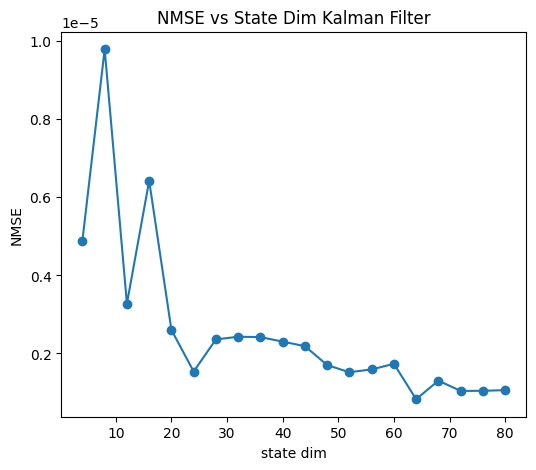

In [7]:
plt.figure(figsize=(6, 5))
plt.plot(state_dims, nmse_list, marker='o')
plt.xlabel("state dim")
plt.ylabel("NMSE")
plt.title("NMSE vs State Dim Kalman Filter")
plt.show()

We can notice that NMSE occilates initially on the level of 1e-5 for K < 10. 
As K gets larger, NMSE stables down and converges to around 5e-6. 
This is because NMSE is usually an average over all 4k state dimensions.
Having more objects means averaging over more terms, and random estimation errors (from process noise, measurement noise, etc.) tend to cancel each other out due to law of Large Numbers

## 1.3

### (a)

Like Kalman filter, we want to sequentially approximate 
the filtering distribution $p(x_t \mid y_{1:t})$ where

\begin{align*}
\pi_0(x_0) &= \mathcal{N}(x_0; m_0, P_0) \\
x_t \sim \tau(x_t | x_{t-1}) &= \mathcal{N}(x_t; A_k x_{t-1}, Q_k) \\
y_t \sim g(y_t | x_t) &= \mathcal{N}(y_t; H_k x_t, R_k)
\end{align*}

Where $x_t, y_t \in R^{4k}$ as before. 
Since we have the same setup as the lecture notes, we reference the BPF pesudocode below:

1. **Sample:**  
$ \bar{x}_0^{(i)} \sim q(x_0) \quad \text{for} \quad i = 1, \ldots, N. $

2. **Weight:**
For $ i = 1, \ldots, N $, 
- compute
$
W_0^{(i)} = \frac{\pi_0(\bar{x}_0^{(i)})}{q(\bar{x}_0^{(i)})},
$

- Compute the normalised weights 
$
w_0^{(i)} = \frac{W_0^{(i)}}{\sum_{j=1}^{N} W_0^{(j)}},
$

3. **Resample:**  
- Sample $ x_0^{(i)} \sim \sum_{i=1}^{N} w_0^{(i)} \delta_{\bar{x}_0^{(i)}}(\mathrm{d}x_0) $ for $ i = 1, \ldots, N $.

4. **for** $ t = 1, \ldots, T $ **do**

5. - **Sample:**  
$ \bar{x}_t^{(i)} \sim \tau_t(\cdot|x_{t-1}^{(i)}) \quad \text{for} \quad i = 1, \ldots, N. $

   - **Weight:**
    $
    W_t^{(i)} = g_t(y_t|\bar{x}_t^{(i)}),
    $
    for $ i = 1, \ldots, N $.

    - compute
    $
    w_t^{(i)} = \frac{W_t^{(i)}}{\sum_{j=1}^{N} W_t^{(j)}},
    $

    - **Resample:**  $ x_t^{(i)} \sim \sum_{i=1}^{N} w_t^{(i)} \delta_{\bar{x}_t^{(i)}}(\mathrm{d}x_t) $ for $ i = 1, \ldots, N $.

**end for**

**Return** the sequence of filtering distributions, either

$$
\pi_t^N(\mathrm{d}x_t|y_{1:t}) = \sum_{i=1}^{N} w_t^{(i)} \delta_{x_t^{(i)}}(\mathrm{d}x_t)
$$

or

$$
\pi_t^N(\mathrm{d}x_t|y_{1:t}) = \frac{1}{N} \sum_{i=1}^{N} \delta_{x_t^{(i)}}(\mathrm{d}x_t).
$$

Here we use $\pi_0$ as proposal, so that $W_0^{(i)} = 1$, and $w_0^{(i)} = \frac{1}{N}$ for all $i$

Therefore we don't need to do the first resample:
$ x_0^{(i)} \sim \sum_{i=1}^{N} w_0^{(i)} \delta_{\bar{x}_0^{(i)}}(\mathrm{d}x_0) $, as we already have a unweighted sample

### (b) Implement BPF

In [8]:
# first define log-likelihood for normal
def log_p(y, y_pred, R):
    '''y: (dim_y,) & y_pred: (N, dim_y), return (N,) array of likelihoods.'''
    dim_y = y.shape[0]
    diff = y_pred - y  # (N, dim_y)
    R_inv = np.linalg.inv(R)
    mahalanobis = np.sum(diff @ R_inv * diff, axis=1)  # (N,)
    log_det_R = np.linalg.slogdet(R)[1]  # More stable than np.log(np.linalg.det(R))
    
    log_likelihoods = -0.5 * (mahalanobis + dim_y * np.log(2 * np.pi) + log_det_R)
    return log_likelihoods


Note to sample $ \bar{x}_t^{(i)} \sim \tau = \mathcal{N}(x_t; A_k x_{t-1}, Q_k)$ for N times, 
we simply define a (N, 4k) vector: 
$x = (\bar{x}_{t-1}^{(1)}, \dots, \bar{x}_{t-1}^{(N)})$

Then the updated mean is given by $ (Ax^T)^T$, which is again a (N, 4k) vector,
where each row is $A_k \bar{x}_{t-1}^{(i)}$

Since we cannot pass in an array of N means into `np.random.normal`, 
we simulate (N, 4k)-shaped $\mathcal{N}(0, Q_k)$ noise, to be added to the updated mean

In [9]:
def bpf(Y, A, Q, H, R, m0, P0, N=500):
    T = len(Y)
    dim_x = len(m0) # 4K
    W = np.zeros((T, N))  # Weights for each particle at each time step
    
    # Step 1: init particles
    x = np.random.multivariate_normal(m0, P0, size=N)  # Shape: (N, dim_x)
    
    particle_history = []

    for t in range(T):
        # Step 2: Propagation, sample from tau(x|xt-1) for N times
        # we vectorize by sampling N*dim_x noise, then add to the mean
        # note x is (N, dim_x) and A is (dim_x, dim_x), so Ax is given by Ax^T
        noise = np.random.multivariate_normal(np.zeros(dim_x), Q, size=N)
        x = (A @ x.T).T + noise  # Shape: (N, dim_x)
        
        # Step 3: Weight Update
        y = Y[t]
        y_pred = (H @ x.T).T  # Shape: (N, dim_y)
        
        # compute Normal(y, y_pred, R), shape (N,)
        diff = y_pred - y
        likelihoods = np.exp(-0.5 * np.sum(diff @ np.linalg.inv(R) * diff, axis=1))
        likelihoods /= np.sqrt((2 * np.pi)**len(y) * np.linalg.det(R))
        
        weights = likelihoods + 1e-300  # avoid numerical issues
        weights /= np.sum(weights)
        W[t] = weights  # Store weights for this time step
        
        # Step 4: Resampling
        indices = np.random.choice(N, size=N, p=weights)
        x = x[indices]
        
        # Save x
        particle_history.append(x.copy())
        
    return particle_history, W

def run_bpf(X, Y, K, N=500, plot_trajectories=False):
    dim = 4 * K
    
    AK = np.kron(np.eye(K), A)
    QK = np.kron(np.eye(K), Q)
    HK = np.kron(np.eye(K), H)
    RK = np.kron(np.eye(K), R)

    # get stored Q_bar for this K
    Q_bar = Q_ks[K]

    m0 = np.tile(np.array([0, 0, -20, 20]), K)
    P0 = np.eye(dim)

    # Step 2: Particle Filtering
    particle_history, weights = bpf(Y, AK, Q_bar, HK, RK, m0, P0, N)
    
    # Step 3: Estimate means
    filtered_means = np.array([x.mean(axis=0) for x in particle_history])
    
    # Step 4: NMSE
    nmse = compute_nmse(X, filtered_means)
    
    if plot_trajectories:
        plt.figure(figsize=(6, 5))
        for k in range(K):
            idx_x = 4*k
            idx_y = 4*k + 1
            plt.plot(X[1:, idx_x], X[1:, idx_y], label=f"True Obj {k+1}", linestyle="--")
            plt.plot(filtered_means[:, idx_x], filtered_means[:, idx_y], label=f"Est. Obj {k+1}")
        plt.xlabel("Position X")
        plt.ylabel("Position Y")
        plt.title(f"Bootstrap Particle Filter: True vs Estimated Trajectories (K={K})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    return nmse, weights


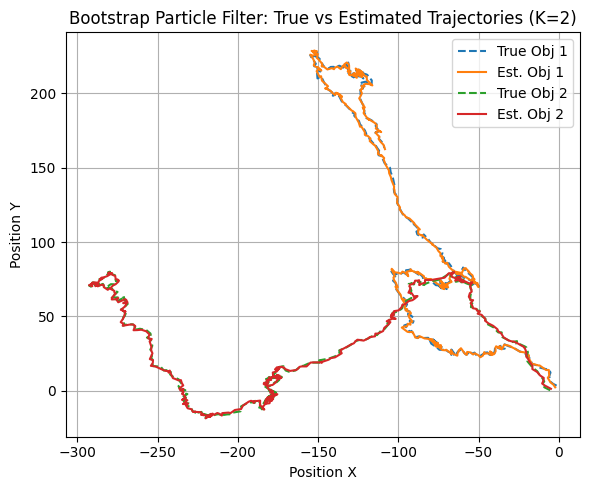

NMSE for BPF K=2: 6.293419567799077e-05


In [10]:
nmse_bpf, _ = run_bpf(X2, Y2, K=2, plot_trajectories=True)
print(f"NMSE for BPF K=2: {nmse_bpf}")

Again we have the visual plot for K = 2 for the sanity check. Visually this looks just as good as the kalman filter plot. We can see that for the 2 objects simulated,
the trajectories of first 2 dims of both objects are almost perfectly estimated by the BPF.
This agrees with the produced NMSE of 6e-05, which is really small.

Now we run BPF for K = 1,2,..,20. Note when we call `run_bpf`, we have saved the $\bar{Q_k}$ in a dictionary, which has a random component. This ensures when we do BPF, we can sample using the same $\tau$ which generated the data.

The data can be generated again using `simulate_MOHMM`, since I have fixed the seed and tested this will generate the same data, and is pretty fast so I did not make an effort to save the data

In [11]:
nmse_bpf_list = []
bpf_weights = {}
for K in range(1, 21):
    X, Y = simulate_MOHMM(K, seed=42)
    nmse, weights = run_bpf(X, Y, K)
    nmse_bpf_list.append(nmse) # store NMSE for each K
    bpf_weights[K] = weights # store weights for each K
nmse_bpf_list = np.array(nmse_bpf_list)

In [12]:
nmse_bpf_list

array([6.08342371e-06, 6.71323634e-05, 6.11864792e-05, 5.22814353e-01,
       1.17529517e+00, 5.15445617e-01, 5.73495761e-01, 1.09202687e+00,
       1.58558228e+00, 1.44661409e+00, 1.32302116e+00, 8.91565346e-01,
       1.04346014e+00, 1.42162380e+00, 1.47799228e+00, 1.11816329e+00,
       1.03641259e+00, 7.80673909e-01, 1.29972809e+00, 1.00495131e+00])

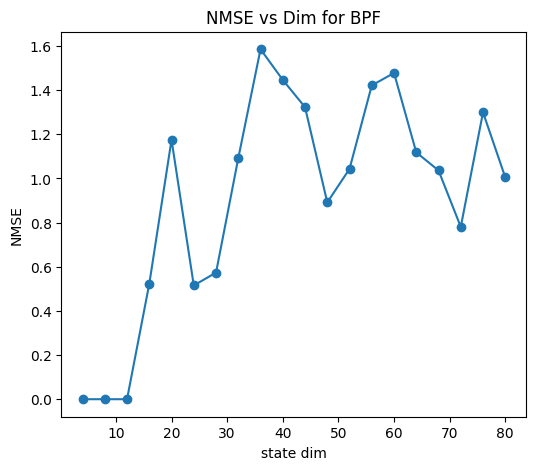

In [13]:
plt.figure(figsize=(6, 5))
plt.plot(state_dims, nmse_bpf_list, marker='o')
plt.xlabel("state dim")
plt.ylabel("NMSE")
plt.title("NMSE vs Dim for BPF")
plt.show()

BPF is having an NMSE that keeps oscillating on the level of 1e-0, with large variances, and no signs of dropping with larger state dims for fixed N.

### (c)

We visually observe that BPF performs worse than Kalman, especially as state dim grows. With Kalman's NMSE oscillating on the level of 1e-5 at the start and decays even smaller as state dim grows, while BPF oscilaltes around 1e-0 with no signs of dropping error as state dim grows. 

To reinforce this belief, I plot Kalman vs BPF on both log scale and linear scale below:

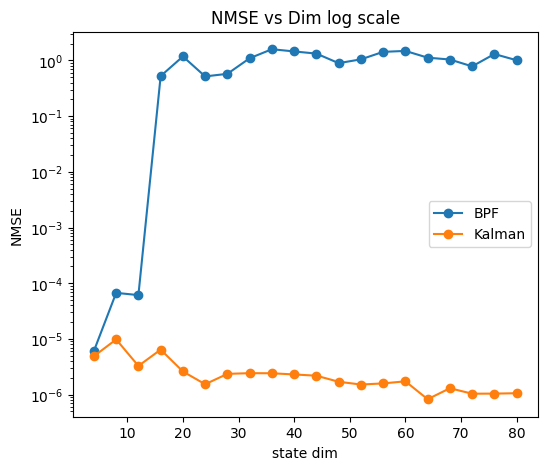

In [14]:
plt.figure(figsize=(6, 5))
plt.plot(state_dims, nmse_bpf_list, marker='o')
plt.plot(state_dims, nmse_list, marker='o')
plt.legend(["BPF", "Kalman"])
plt.yscale("log")
plt.xlabel("state dim")
plt.ylabel("NMSE")
plt.title("NMSE vs Dim log scale")
plt.show()

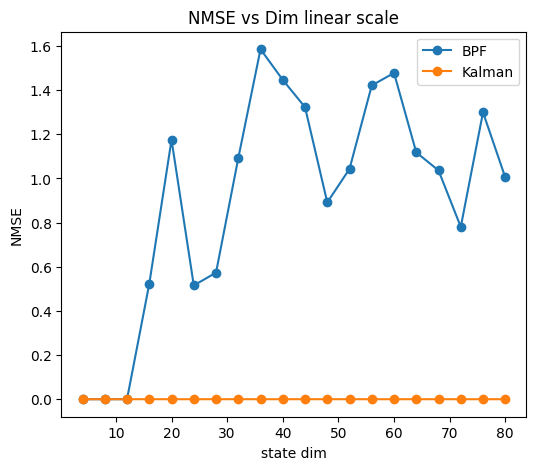

In [15]:
plt.figure(figsize=(6, 5))
plt.plot(state_dims, nmse_bpf_list, marker='o')
plt.plot(state_dims, nmse_list, marker='o')
plt.legend(["BPF", "Kalman"])
plt.xlabel("state dim")
plt.ylabel("NMSE")
plt.title("NMSE vs Dim linear scale")
plt.show()

We can see that Kalman clearly dominates BPF, this performance gap tends to widen as the state dimension increases.  
This is because Kalman performs well as the underlying system dynamics and observation models are linear with Gaussian noise.

As the state dimension increases, the performance of BPF tends to degrade unless the number of particles is scaled up exponentially. This is due to the curse of dimensionality: in high dimensions, the particles spread thinly across the state space, and the effective sample size drops, leading to degeneracy (where only a few particles have non-negligible weights). Without resampling strategies or advanced variants, BPF struggles in high-dimensional settings.

### (d) 
we visually observe that the fourth datapoint of BPF goes above 0.5. To confirm this guess, we print:

In [16]:
nmse_bpf_list[:5]

array([6.08342371e-06, 6.71323634e-05, 6.11864792e-05, 5.22814353e-01,
       1.17529517e+00])

so K = 4 is smallest where BPF fails for N = 500

In [17]:
nmse_bpf_k4 = []
M = 3
N_list = [100, 500, 1000, 5000, 10000]
X, Y = simulate_MOHMM(K=4, seed=42)
for n in N_list:
    nmse = 0
    for _ in range(M): # run BPF M times
        nmse_m, _ = run_bpf(X, Y, K=4, N = n)
        nmse += nmse_m
    nmse /= M
    nmse_bpf_k4.append(nmse)
# nmse_bpf_k4 = np.array(nmse_bpf_k4)
nmse_bpf_k4

[3.3619802939884806,
 0.41871909599396534,
 0.26946238613747364,
 0.00015690732757633367,
 0.00012718256912042637]

Text(0.5, 1.0, 'NMSE vs Number of Particles for K=4')

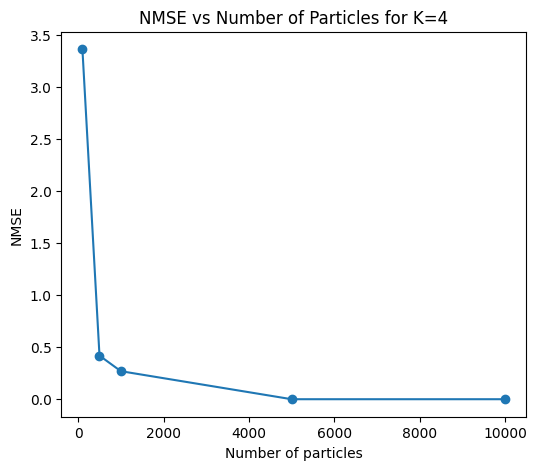

In [18]:
plt.figure(figsize=(6, 5))
plt.plot(N_list, nmse_bpf_k4, marker='o')
plt.xlabel("Number of particles")
plt.ylabel("NMSE")
plt.title("NMSE vs Number of Particles for K=4")

We identify that the rate of convergence is around $O(\sqrt{N})$. 

To verify, we do a log-log plot and do linear regression, and verfiy the slope to be around -0.5

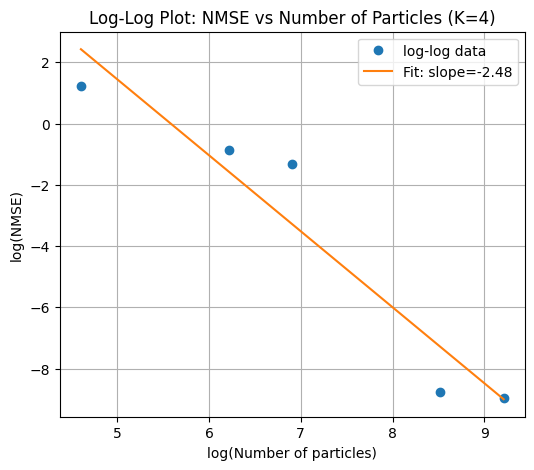

Estimated slope: -2.481


In [19]:
from scipy.stats import linregress

# Convert to numpy arrays
N = np.array(N_list)
nmse_bpf_k4 = np.array(nmse_bpf_k4)

# Log-log transform
log_N = np.log(N)
log_nmse_bpf_k4 = np.log(nmse_bpf_k4)

# Linear regression in log-log space
slope, intercept, r_value, p_value, std_err = linregress(log_N, log_nmse_bpf_k4)

# Plot the log-log relationship
plt.figure(figsize=(6, 5))
plt.plot(log_N, log_nmse_bpf_k4, 'o', label='log-log data')
plt.plot(log_N, intercept + slope * log_N, label=f'Fit: slope={slope:.2f}')
plt.xlabel("log(Number of particles)")
plt.ylabel("log(NMSE)")
plt.title("Log-Log Plot: NMSE vs Number of Particles (K=4)")
plt.legend()
plt.grid(True)
plt.show()

# Print slope to check scaling
print(f"Estimated slope: {slope:.3f}")


The justification for this decay rate is the result we quote from theorem 4.1:


Assume that the likelihood function is positive and bounded

$$
g_n(x_n) > 0 \quad \text{and} \quad \|g_n\|_\infty < \infty.
$$

for all  $ n \geq N $. Then, for any  $ p \geq 1 $  and  $ N \geq 1 $, we have

$$
\|(\varphi, \pi_n^N) - (\varphi, \pi_n)\|_p \leq \frac{c_n \|\varphi\|_\infty}{\sqrt{N}},
$$

WHere $c_n$ is a constant that depends on the model and the sequence of observations.


## 1.4

### (a)

Recall our setup:
\begin{align*}
x_0 &\sim \mathcal{N}(m_0, P_0) \\
x_t \mid x_{t-1} &\sim \mathcal{N}(A x_{t-1}, Q) \\
y_t \mid x_t &\sim \mathcal{N}(H x_t, R)
\end{align*}

We quote from lecture notes that the optimal proposal is given by $p(x_t | x_{t-1}, y_t)$, derived as follow:

$$
p(x_t | x_{t-1}, y_t) \propto p(x_t | x_{t-1}) p(y_t | x_t)
$$

$$
\propto \mathcal{N}(x_t; A x_{t-1}, Q) \cdot \mathcal{N}(y; H x_t, R)
$$

$$
= \mathcal{N}(x_t; \tilde{m}_t, \tilde{P}),
$$

where there are two equivalent ways of deriving $\tilde{m}_t, \tilde{P}$. The first way is to use Lemma 3.1:

$$
\tilde{P} = Q - Q H^T (R + HQH^T)^{-1} HQ
$$

$$
\tilde{m}_t = AX_{t-1} + Q H^T (R + HQH^T)^{-1}(Y - HAX_{t-1})
$$

The second way is more elegant (and used in Example 4.1):

$$
\tilde{P} = (Q^{-1} + H^\top R^{-1} H)^{-1}
$$

$$
\tilde{m}_t = \tilde{P} \left( Q^{-1} AX_{t-1} + H^\top R^{-1} y_t \right).
$$

We check that they are equivalent here:

In [20]:
def method1(A, Q, H, R, X_t_minus_1, Y):
    """
    Computes tilde_P and tilde_m_t using Lemma 3.1:
    tilde_P = Q - Q H^T (R + HQH^T)^{-1} HQ
    tilde_m_t = AX_{t-1} + Q H^T (R + HQH^T)^{-1}(Y - HAX_{t-1})
    """
    HQ = H @ Q
    S = R + HQ @ H.T
    S_inv = np.linalg.inv(S)
    
    tilde_P = Q - Q @ H.T @ S_inv @ HQ

    AX = X_t_minus_1 @ A.T  # (N, d)
    HAX = AX @ H.T          # (N, m)
    tilde_m = AX + (Y - HAX) @ (Q @ H.T @ S_inv).T  # (N, d)
    
    return tilde_P, tilde_m

def method2(A, Q, H, R, X_t_minus_1, Y):
    """
    tilde_P = (Q^{-1} + H^T R^{-1} H)^{-1}
    tilde_m_t = tilde_P (Q^{-1} A x_{t-1} + H^T R^{-1} y_t)
    """
    Q_inv = np.linalg.inv(Q)
    R_inv = np.linalg.inv(R)
    tilde_P_inv = Q_inv + H.T @ R_inv @ H
    tilde_P = np.linalg.inv(tilde_P_inv)

    AX = X_t_minus_1 @ A.T                # (N, d)
    tilde_m = (AX @ Q_inv.T + Y @ R_inv @ H) @ tilde_P.T  # (N, d)
    
    return tilde_P, tilde_m

print('checking if two methods agree on random input')
X_t_minus_1, Y = np.random.randn(1, 4), np.random.randn(4)
output1 = method1(A, Q, H, R, X_t_minus_1, Y)
output2 = method2(A, Q, H, R, X_t_minus_1, Y)

print(output1)
print(output2)

checking if two methods agree on random input
(array([[0.0002079 , 0.        , 0.0024948 , 0.        ],
       [0.        , 0.0002079 , 0.        , 0.0024948 ],
       [0.0024948 , 0.        , 0.04993763, 0.        ],
       [0.        , 0.0024948 , 0.        , 0.04993763]]), array([[ 0.55188365, -0.77204814, -0.10714494, -0.75220872]]))
(array([[0.0002079 , 0.        , 0.0024948 , 0.        ],
       [0.        , 0.0002079 , 0.        , 0.0024948 ],
       [0.0024948 , 0.        , 0.04993763, 0.        ],
       [0.        , 0.0024948 , 0.        , 0.04993763]]), array([[ 0.55188365, -0.77204814, -0.10714494, -0.75220872]]))


Furthermore, we quote from the lecture notes, that the optimal weights are given by

$$
w_t^{(i)} \propto p(y_t \mid x_{t-1})
$$

Where we have

$$
p(y_t \mid x_{t-1})
\;=\;\int p(y_t \mid x_{t})\,p(x_t \mid x_{t-1})\,dx_t
$$

$$
= \int \mathcal{N}(x_t; A x_{t-1}, Q) \cdot \mathcal{N}(y; H x_t, R) dx_t
$$

We can use Lemma 3.2:

$$
p(y_t \mid x_{t-1}) = \mathcal{N}(y_t; H A x_{t-1}, R + H Q H^\top).
$$


#### Pseudocode of Optimal Particle Filter

1. **Sample:**  
$ \bar{x}_0^{(i)} \sim q(x_0) \quad \text{for} \quad i = 1, \ldots, N. $

2. **Weight:**
For $ i = 1, \ldots, N $, 
- compute
$
W_0^{(i)} = \frac{\pi_0(\bar{x}_0^{(i)})}{q(\bar{x}_0^{(i)})},
$

- Compute the normalised weights 
$
w_0^{(i)} = \frac{W_0^{(i)}}{\sum_{j=1}^{N} W_0^{(j)}},
$

3. **Resample:**  
- Sample $ x_0^{(i)} \sim \sum_{i=1}^{N} w_0^{(i)} \delta_{\bar{x}_0^{(i)}}(\mathrm{d}x_0) $ for $ i = 1, \ldots, N $.

4. **for** $ n = 1, \ldots, T $ **do**

5. - **Sample:**  
$ \bar{x}_t^{(i)} \sim p(x_t | x_{t-1}, y_t) = \mathcal{N}(x_t; \tilde{m}_t, \tilde{P}), \quad \text{for} \quad i = 1, \ldots, N. $

   - **Weight:**
    $
    W_t^{(i)} = p(y_t \mid x_{t-1}) =  \mathcal{N}(y_t; H A x_{t-1}, R + H Q H^\top).
    $
    for $ i = 1, \ldots, N $.

    - compute
    $
    w_t^{(i)} = \frac{W_t^{(i)}}{\sum_{j=1}^{N} W_t^{(j)}},
    $

    - **Resample:**  $ x_t^{(i)} \sim \sum_{i=1}^{N} w_t^{(i)} \delta_{\bar{x}_t^{(i)}}(\mathrm{d}x_t) $ for $ i = 1, \ldots, N $.

**end for**

**Return** the sequence of filtering distributions, either

$$
\pi_t^N(\mathrm{d}x_t|y_{1:t}) = \sum_{i=1}^{N} w_t^{(i)} \delta_{x_t^{(i)}}(\mathrm{d}x_t)
$$

or

$$
\pi_t^N(\mathrm{d}x_t|y_{1:t}) = \frac{1}{N} \sum_{i=1}^{N} \delta_{x_t^{(i)}}(\mathrm{d}x_t).
$$

### (b) Implementation of OptPF

In [21]:
def bpf_optimal(Y, A, Q, H, R, m0, P0, N=500):
    T = len(Y)
    dim_x = len(m0) # 4K
    W = np.zeros((T, N))  # Weights for each particle at each time step
    
    # Step 1: init particles
    x = np.random.multivariate_normal(m0, P0, size=N)  # Shape: (N, dim_x)
    
    particle_history = []

    for t in range(T):
        # Step 2: Propagation, sample from optimal proposal p(xn | xn-1, yn) for N times
        y = Y[t]
        tilde_P, tilde_m =  method1(A, Q, H, R, x, y) # M has shape (N, dimx), P has shape (N, dim_x, dim_x)
        x = np.random.multivariate_normal(np.zeros(dim_x), tilde_P, size=N) + tilde_m  # Shape: (N, dim_x)
        
        # Step 3: Weight Update = N(HAX_{t-1}, R+HQH^T)
        # y_pred = HAX_{t-1} 
        y_pred = (H @ A @ x.T).T  # Shape: (N, dim_y)
        
        # compute optimal weight = Normal(y; y_pred, R + HQHT), shape (N,)
        diff = y_pred - y
        likelihoods = np.exp(-0.5 * np.sum(diff @ np.linalg.inv(R + H @ Q @ H.T) * diff, axis=1))
        likelihoods /= np.sqrt((2 * np.pi)**len(y) * np.linalg.det(R + H @ Q @ H.T))

        weights = likelihoods + 1e-300  # avoid numerical issues
        weights /= np.sum(weights)
        W[t] = weights
        
        # Step 4: Resampling
        indices = np.random.choice(N, size=N, p=weights)
        x = x[indices]
        
        # Save x
        particle_history.append(x.copy())
        
    return particle_history, W



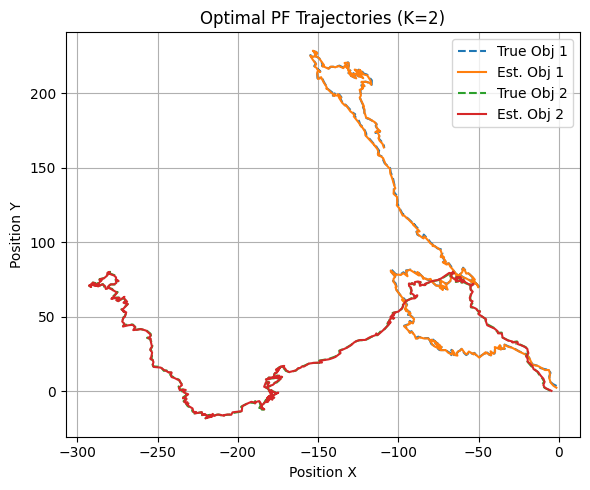

NMSE for Optimal PF K=2: 1.3600325599376745e-05


In [22]:
def run_optPF(X, Y, K, N=500, plot_trajectories=False):
    dim = 4 * K
    
    AK = np.kron(np.eye(K), A)
    QK = np.kron(np.eye(K), Q)
    HK = np.kron(np.eye(K), H)
    RK = np.kron(np.eye(K), R)

    # get stored Q_bar for this K
    Q_bar = Q_ks[K]

    m0 = np.tile(np.array([0, 0, -20, 20]), K)
    P0 = np.eye(dim)

    # Step 2: Particle Filtering
    particle_history, weights = bpf_optimal(Y, AK, Q_bar, HK, RK, m0, P0, N)


    # Step 3: Estimate means
    filtered_means = np.array([x.mean(axis=0) for x in particle_history])
    
    # Step 4: NMSE
    nmse = compute_nmse(X, filtered_means)
    
    if plot_trajectories:
        plt.figure(figsize=(6, 5))
        for k in range(K):
            idx_x = 4*k
            idx_y = 4*k + 1
            plt.plot(X[1:, idx_x], X[1:, idx_y], label=f"True Obj {k+1}", linestyle="--")
            plt.plot(filtered_means[:, idx_x], filtered_means[:, idx_y], label=f"Est. Obj {k+1}")
        plt.xlabel("Position X")
        plt.ylabel("Position Y")
        plt.title(f"Optimal PF Trajectories (K={K})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    return nmse, weights

nmse_optPF, _ = run_optPF(X2, Y2, K=2, plot_trajectories=True)
print(f"NMSE for Optimal PF K=2: {nmse_optPF}")

We have the optimal PF visual plot for K = 2 for the sanity check. Visually this looks slightly better than the BPF plot. 

We can see that for the 2 objects simulated, the trajectories of first 2 dims of both objects are almost perfectly estimated by the optimal PF. This agrees with the produced NMSE of 1e-05, which is even smaller than 6e-05 NMSE of BPF, and on the same level as Kalman filter.

Now we run PF for K = 1,2,..,20. 
Again when we call `simulate_MOHMM`, we save the used Q_bar in a dictionary, to be used by `run_optPF`, since it has a random component. 

For each K, we use M = 3 simulations and take the average.

In [23]:
nmse_opt_list = []
opt_weights = {}
M = 3
for K in range(1, 21):
    X, Y = simulate_MOHMM(K, seed=42)
    nmse = 0
    for _ in range(M): # run OptPF M times
        nmse_k, w_k = run_optPF(X, Y, K, N = 500)
        nmse += nmse_k
    nmse /= M
    nmse_opt_list.append(nmse)
    opt_weights[K] = w_k # store weights for each K
nmse_opt_list = np.array(nmse_opt_list)

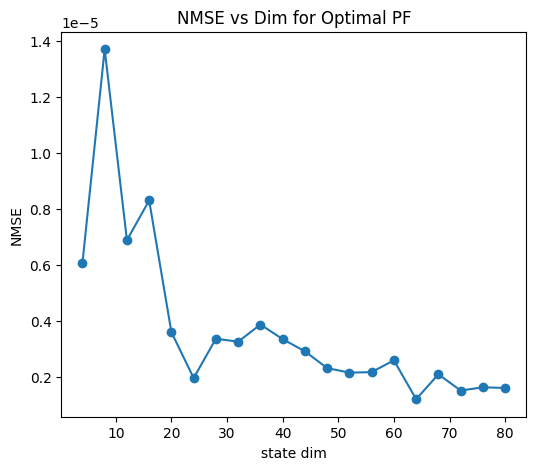

In [24]:
plt.figure(figsize=(6, 5))
plt.plot(state_dims, nmse_opt_list, marker='o')
plt.xlabel("state dim")
plt.ylabel("NMSE")
plt.title("NMSE vs Dim for Optimal PF")
plt.show()

From the NMSE plot, we can see OptiPF has similar performance comparable with Kalman filter, and better than BPF.

Both Kalman and OptPF stays below level of 1e-5, with some initial oscilallations but quickly stables down and converges to 0 as state dim increases. This is clearly better then BPF, which not only has higher NMSE with large oscillations throughout, and show no sign of convergence.

### (c)

In [25]:
# check shape of weights
bpf_weights[4].shape, opt_weights[4].shape

((400, 500), (400, 500))

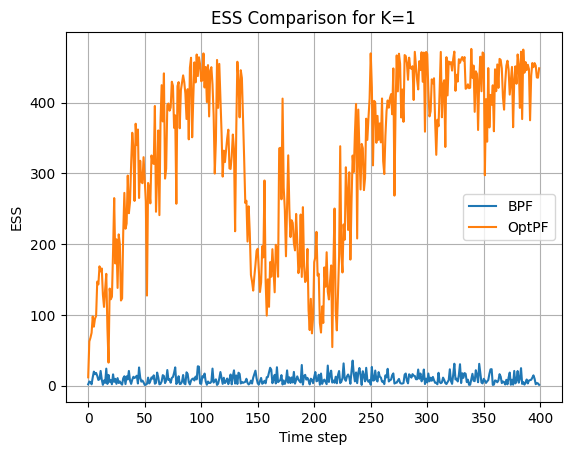

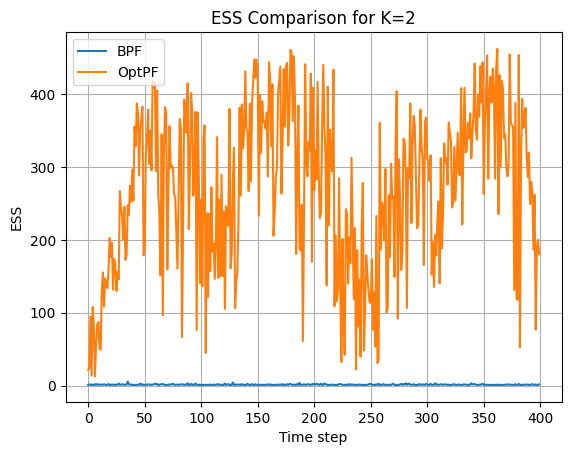

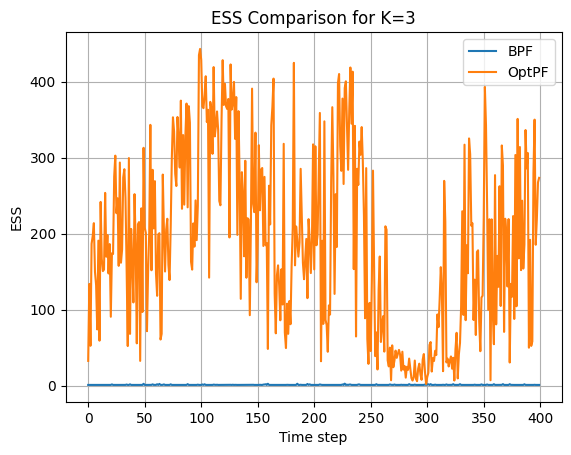

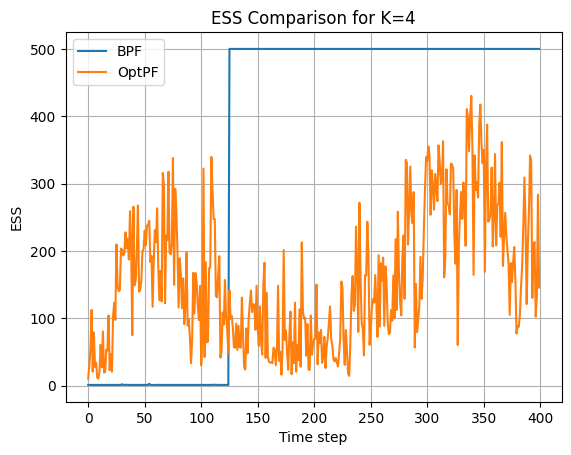

In [26]:
def ESS(w):  # To measure sample quality
    return 1 / np.sum(w**2)
T, N = 400, 500
for K in range(1, 5):
    ESS_bpf = np.array([ESS(bpf_weights[K][i]) for i in range(T)])
    ESS_optpf = np.array([ESS(opt_weights[K][i]) for i in range(T)])

    plt.figure()  # New figure for each K
    plt.plot(np.arange(len(ESS_bpf)), ESS_bpf, label='BPF')
    plt.plot(np.arange(len(ESS_optpf)), ESS_optpf, label='OptPF')
    plt.xlabel('Time step')
    plt.ylabel('ESS')
    plt.title(f'ESS Comparison for K={K}')
    plt.legend()
    plt.grid(True)
